In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# from pandas.plotting import register_matplotlib_converters
# register_matplotlib_converters()

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/sm-joo/sm-joo/master/DEXKOUS.csv', parse_dates=['DATE'], index_col='DATE')

In [3]:
df.columns =['KOUS']
df['KOUS'].replace('.', '', inplace =True)
df['KOUS'] = pd.to_numeric(df['KOUS'])
df['KOUS'].fillna(method = 'ffill', inplace = True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1306 entries, 2015-03-13 to 2020-03-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   KOUS    1306 non-null   float64
dtypes: float64(1)
memory usage: 20.4 KB


In [5]:
df = df[(df.index>'2019-01-01') & (df.index < '2020-01-01')]

# ARIMA(p,k,q) => k 결정

In [6]:
adfuller(df.KOUS)

(-1.834289925068011,
 0.36357542996557135,
 2,
 257,
 {'1%': -3.4560535712549925,
  '10%': -2.5727985212493754,
  '5%': -2.8728527662442334},
 1453.3457437081727)

p-valuer가가 0.36으로 귀무가설이이 기각되지 않는다 -> 안정적이지 않다 따라서 차분이 필요하다

In [7]:
adfuller(df.KOUS.diff().dropna())

(-10.572632524492832,
 7.239046680336767e-19,
 1,
 257,
 {'1%': -3.4560535712549925,
  '10%': -2.5727985212493754,
  '5%': -2.8728527662442334},
 1446.168602565303)

K = 1로 (1차 차분이 안정적이다)

# ARIMA(p,k,q) => p, q 결정

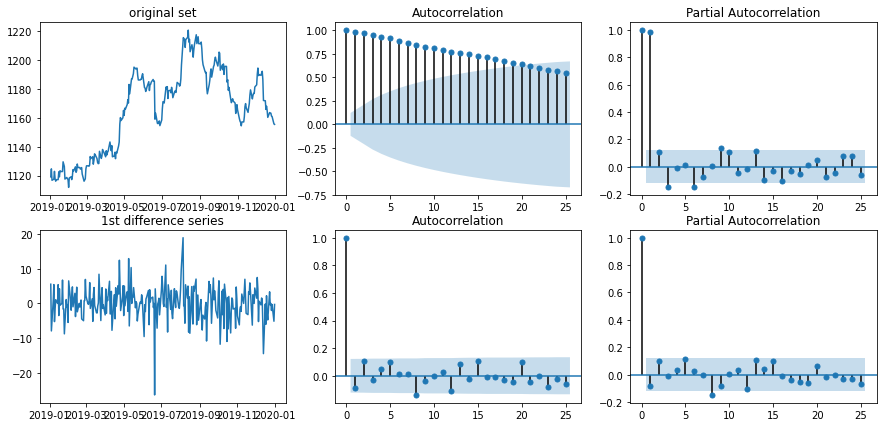

In [9]:
figure, axes =plt.subplots(2, 3, figsize =(15,7))
axes[0,0].plot(df.KOUS)
axes[0,0].set_title('original set')
axes[1,0].plot(df.KOUS.diff())
axes[1,0].set_title('1st difference series')
plot_acf(df.KOUS, axes[0,1])
plot_pacf(df.KOUS, axes[0,2])
plot_acf(df.KOUS.diff().dropna(), axes[1,1])
plot_pacf(df.KOUS.diff().dropna(), axes[1,2])
plt.show()

```
AR차수는 1차 ~ 3차
MA차수는 0차 ~ 2차
```

# ARIMA 예측 모델링


In [10]:
model = ARIMA(df.KOUS, order = (3,1,2), freq = 'B')
model_fit = model.fit(trend = 'nc')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.KOUS   No. Observations:                  259
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -768.706
Method:                       css-mle   S.D. of innovations              4.677
Date:                Sat, 02 Jul 2022   AIC                           1549.412
Time:                        06:10:33   BIC                           1570.753
Sample:                    01-03-2019   HQIC                          1557.992
                         - 12-31-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.D.KOUS    -0.2878      0.064     -4.504      0.000      -0.413      -0.163
ar.L2.D.KOUS    -0.9557      0.030    -31.909      0.000      -1.014      -0.897
ar.L3.D.KOUS    -0.0885      0.064     -1.387      0.167      -0.214       0.037
ma.L1.D.KOUS     0.2070      0.017     12.534      0.000       0.175       0.239
ma.L2.D.KOUS     1.0000      0.019     52.527      0.000       0.963       1.037
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.1032           -1.0277j            1.0329           -0.2659
AR.2           -0.1032           +1.0277j            1.0329            0.2659
AR.3          -10.5914           -0.0000j           10.5914           -0.5000
MA.1           -0.1035           -0.9946j            1.0000           -0.2665
MA.2           -0.1035           +0.9946j            1.0000            0.2665
-----------------------------------------------------------------------------
"""

< summary 해석 >
- AR
  - coef :  환율이 한번 튀었을때 다음 차수 그다음차수 3차수까지 3번은 환율이 떨어진다
- mA
  - coef : 외부에서 충격이 왔을때  올라가는 충격이 왔을때 2차수 정도 올라가는 충격이 지속된다.
- p-value 
  - 0.05보다 작아야지 안정성이 있으므로 AR(3)은 제외

In [11]:
model = ARIMA(df.KOUS, order = (2,1,2), freq = 'B')
model_fit = model.fit(trend = 'nc')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.KOUS   No. Observations:                  259
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -769.208
Method:                       css-mle   S.D. of innovations              4.715
Date:                Sat, 02 Jul 2022   AIC                           1548.416
Time:                        06:22:45   BIC                           1566.200
Sample:                    01-03-2019   HQIC                          1555.566
                         - 12-31-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.D.KOUS    -1.2447      0.243     -5.123      0.000      -1.721      -0.768
ar.L2.D.KOUS    -0.7340      0.257     -2.851      0.005      -1.239      -0.229
ma.L1.D.KOUS     1.1778      0.245      4.802      0.000       0.697       1.658
ma.L2.D.KOUS     0.7424      0.254      2.923      0.004       0.245       1.240
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8479           -0.8022j            1.1672           -0.3794
AR.2           -0.8479           +0.8022j            1.1672            0.3794
MA.1           -0.7932           -0.8472j            1.1606           -0.3698
MA.2           -0.7932           +0.8472j            1.1606            0.3698
-----------------------------------------------------------------------------
"""

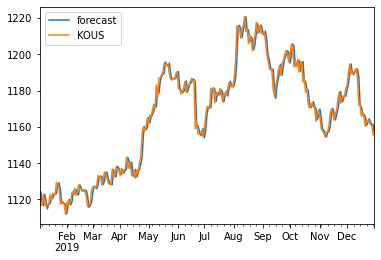

In [12]:
# 전혀의미없지만 이런함수도 있다. 학습한데이터와 같은 데이터를 테스트로 돌려서 예측 plot을 그리는것인데 의미가....
model_fit.plot_predict()
plt.show()

# train/ test split

arima계열 데이터는 데이터가 너무많으면 예측하기에 별로안좋다??

In [14]:
train = df.iloc[0:30]
test = df.iloc[30:35]

In [15]:
model = ARIMA(train, order = (2,1,2), freq = 'B')
model_fit = model.fit(trend = 'nc')
model_fit.forecast(5, alpha = 0.05)

(array([1122.71126571, 1123.35492383, 1123.72752319, 1123.72485447,
        1123.51270791]),
 array([3.55653204, 4.20720366, 4.80873165, 5.7449708 , 6.93432529]),
 array([[1115.740591  , 1129.68194043],
        [1115.10895618, 1131.60089147],
        [1114.30258234, 1133.15246404],
        [1112.46491861, 1134.98479032],
        [1109.92168007, 1137.10373574]]))

첫 번째 array : 예측 값

두 번째 array : 표준에러

세 번째 array : 신뢰구간 [하한, 상한]

In [16]:
fc, se, coef = model_fit.forecast(5, alpha = 0.05)

In [18]:
# 예측값 인덱스 넣기
fc_data = pd.Series(fc, index = test.index)

# 신뢰구간 인덱스 넣기
lower_data = pd.Series(coef[:,0], index = test.index)
upper_data = pd.Series(coef[:,1], index = test.index )

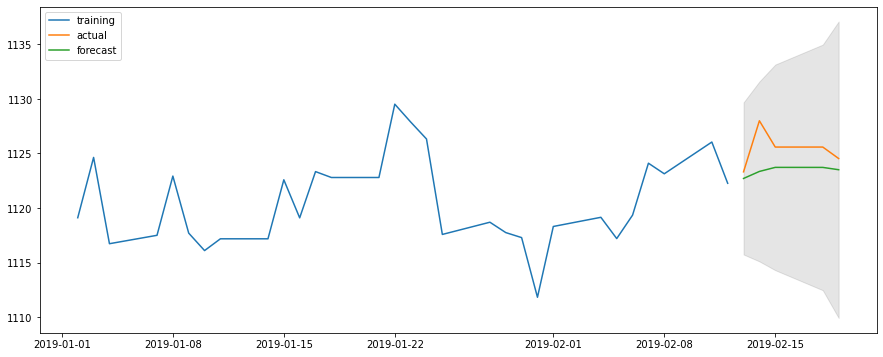

In [21]:
# VIZ
plt.figure(figsize =(15, 6))
plt.plot(train, label = 'training')
plt.plot(test, label = 'actual')
plt.plot(fc_data, label = 'forecast')
plt.fill_between(test.index, lower_data, upper_data, color = 'black', alpha = 0.1)
plt.legend(loc = 'upper left')
plt.show()

ARIMA 모형의 한계는 기존의 패턴으로 예측하기에 외부 요인으로 튄경우를 예측하지 못하는데 VAR(Vector Auto Regression)같은 모델을 활용하여 Multivariate time series forecasting 을 해야한다.